In [19]:
# Feature.ipynb
# =========================
# This demonstrates various feature extraction techniques on sample leaf images.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os                       # For file and directory operations
import cv2                      # OpenCV for image processing
import numpy as np              # NumPy for array operations
import matplotlib.pyplot as plt # Matplotlib for visualizations
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops  # Texture features
from skimage import filters     # LoG filter

In [22]:
# 1. Here, we define paths and sample images
# Base path to dataset in Drive
base_path = '/content/drive/MyDrive/archive/train/train'
# List of class folders in train directory
class_names = [d for d in sorted(os.listdir(base_path)) if os.path.isdir(os.path.join(base_path, d))]
# We will pick the first image from each of the first three classes for demonstration
sample_images = []  # to store (image, class_name)
for cls in class_names[:3]:
    cls_folder = os.path.join(base_path, cls)
    # Listing all image files in this class folder
    files = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.jpg', '.png'))]
    # Reading the first image found
    img = cv2.imread(os.path.join(cls_folder, files[0]))
    # Checking successful load
    if img is not None:
        sample_images.append((img, cls))
    else:
        print(f"Warning: could not load image for class {cls}")

In [23]:
# 2. Edge Detection Demonstrations
# We will show Sobel, Prewitt, Canny, and Laplacian of Gaussian for one sample image
edge_img, edge_cls = sample_images[0]  # take first sample
# Converting to grayscale for edge detection
gray = cv2.cvtColor(edge_img, cv2.COLOR_BGR2GRAY)

# Sobel (x and y)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)  # combine gradients

# Prewitt (custom kernels)
prewitt_kernel_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
prewitt_kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
pre_x = cv2.filter2D(gray, cv2.CV_64F, prewitt_kernel_x)
pre_y = cv2.filter2D(gray, cv2.CV_64F, prewitt_kernel_y)
prewitt = cv2.magnitude(pre_x, pre_y)

# Canny (two-threshold)
canny = cv2.Canny(gray, 100, 200)

# Laplacian of Gaussian (LoG)
log = filters.laplace(gray)

# Normalize to byte image for display
log_norm = (log - log.min()) / (log.max() - log.min())
log_img = (log_norm * 255).astype(np.uint8)

In [24]:
# 3. Corner Detection Demonstrations
# Harris Corner Detection
harris = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
harris = cv2.dilate(harris, None)  # dilate to mark the corners
harris_img = edge_img.copy()
harris_img[harris > 0.01 * harris.max()] = [0, 0, 255]  # mark corners in red

# Shi-Tomasi Corner Detection
corners = cv2.goodFeaturesToTrack(gray, maxCorners=50, qualityLevel=0.01, minDistance=10)
shi_img = edge_img.copy()
for corner in corners.astype(int):  # draw small circles
    x, y = corner.ravel()
    cv2.circle(shi_img, (x, y), 3, (0, 255, 0), -1)

In [25]:
# 4. Texture Analysis Demonstrations
# Local Binary Pattern (LBP)
radius = 1                      # Radius for circular neighborhood
n_points = 8 * radius           # Number of sampling points on the circle
lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

# Compute histogram of LBP
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
# Normalize histogram
hist = hist.astype(float) / hist.sum()

# Gray-Level Co-occurrence Matrix (GLCM)
distances = [1]  # pixel distances
directions = [0]  # angles (0 degrees)
glc_matrix = graycomatrix(gray, distances, directions, levels=256, symmetric=True, normed=True)
# Compute properties
disper = graycoprops(glc_matrix, 'dissimilarity')[0, 0]
contrast = graycoprops(glc_matrix, 'contrast')[0, 0]

In [26]:
# 5. Color Feature Demonstration (HSV Histogram)
hsv = cv2.cvtColor(edge_img, cv2.COLOR_BGR2HSV)
h_bins = 8; s_bins = 8; v_bins = 8  # number of bins per channel
hist_h = cv2.calcHist([hsv], [0], None, [h_bins], [0, 180])
hist_s = cv2.calcHist([hsv], [1], None, [s_bins], [0, 256])
hist_v = cv2.calcHist([hsv], [2], None, [v_bins], [0, 256])
# Normalize histograms
hist_h = hist_h / hist_h.sum()
hist_s = hist_s / hist_s.sum()
hist_v = hist_v / hist_v.sum()

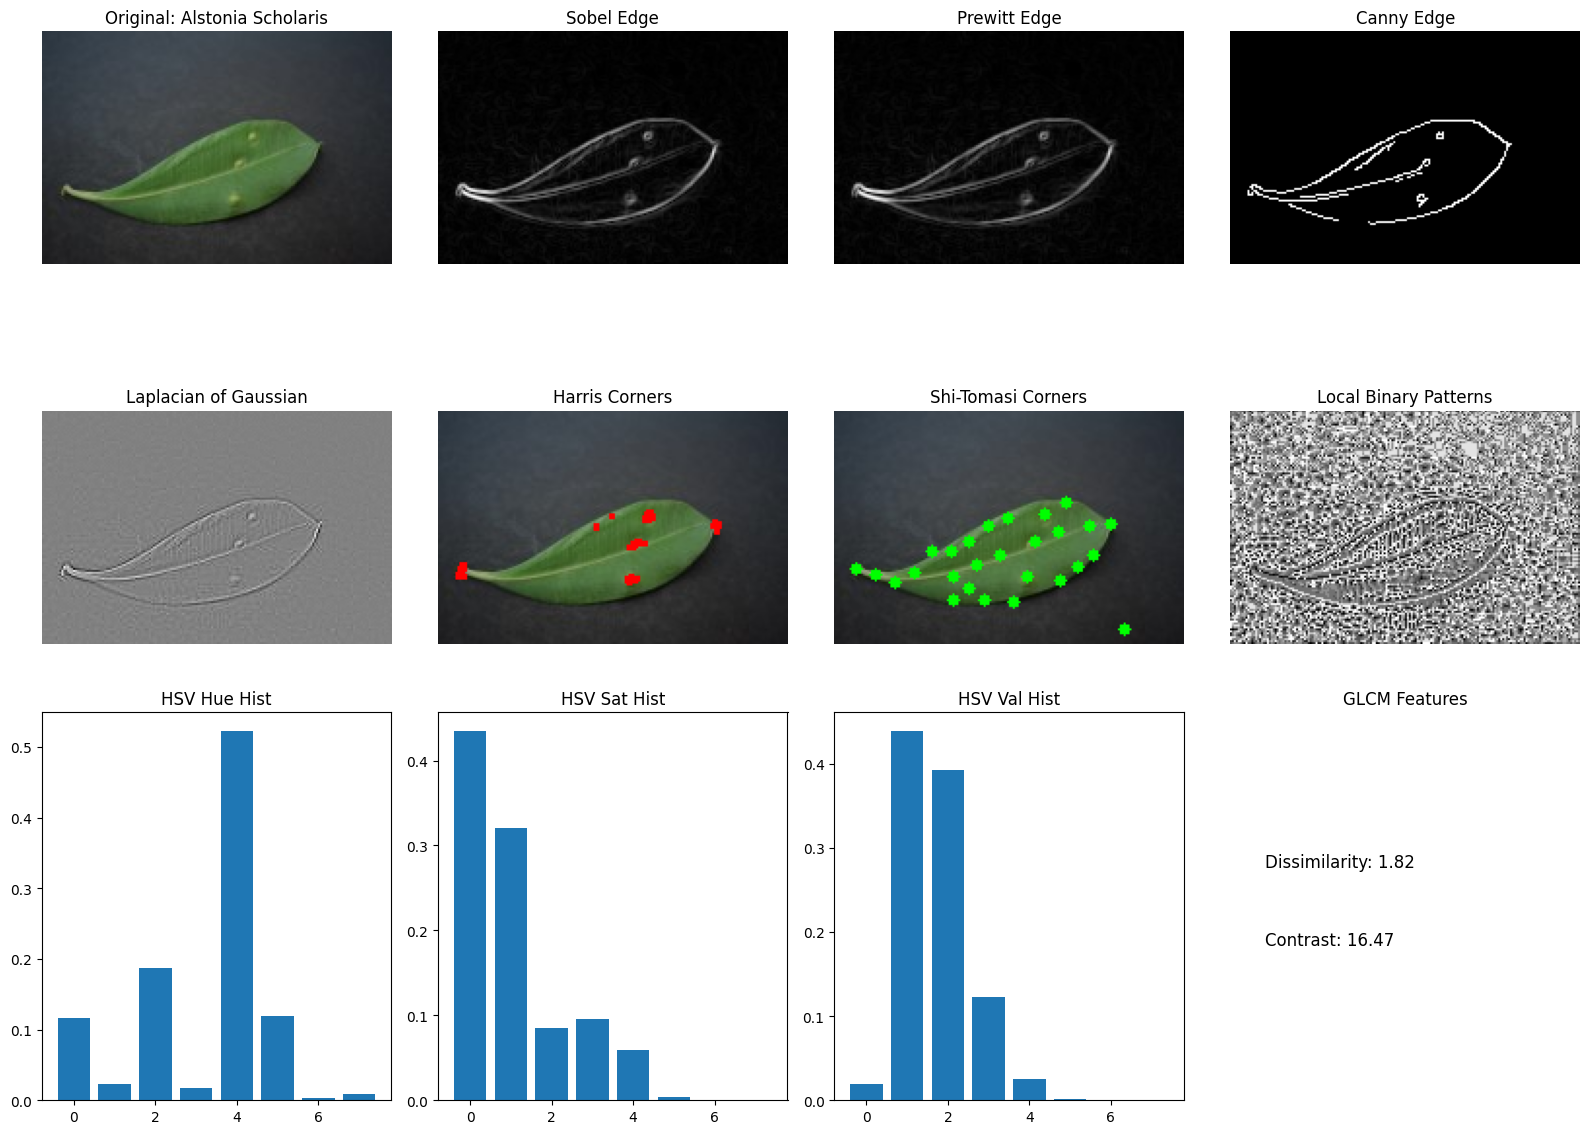

In [27]:
# 6. Visualization
# Create a 3x4 grid to display results
fig, axs = plt.subplots(3, 4, figsize=(16, 12))

# Original image
axs[0, 0].imshow(cv2.cvtColor(edge_img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title(f'Original: {edge_cls}')
axs[0, 0].axis('off')

# Sobel
axs[0, 1].imshow(sobel, cmap='gray')
axs[0, 1].set_title('Sobel Edge')
axs[0, 1].axis('off')

# Prewitt
axs[0, 2].imshow(prewitt, cmap='gray')
axs[0, 2].set_title('Prewitt Edge')
axs[0, 2].axis('off')

# Canny
axs[0, 3].imshow(canny, cmap='gray')
axs[0, 3].set_title('Canny Edge')
axs[0, 3].axis('off')

# LoG
axs[1, 0].imshow(log_img, cmap='gray')
axs[1, 0].set_title('Laplacian of Gaussian')
axs[1, 0].axis('off')

# Harris
axs[1, 1].imshow(cv2.cvtColor(harris_img, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Harris Corners')
axs[1, 1].axis('off')

# Shi-Tomasi
axs[1, 2].imshow(cv2.cvtColor(shi_img, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title('Shi-Tomasi Corners')
axs[1, 2].axis('off')

# LBP
axs[1, 3].imshow(lbp, cmap='gray')
axs[1, 3].set_title('Local Binary Patterns')
axs[1, 3].axis('off')

# HSV H
axs[2, 0].bar(range(h_bins), hist_h.flatten())
axs[2, 0].set_title('HSV Hue Hist')

# HSV S
axs[2, 1].bar(range(s_bins), hist_s.flatten())
axs[2, 1].set_title('HSV Sat Hist')

# HSV V
axs[2, 2].bar(range(v_bins), hist_v.flatten())
axs[2, 2].set_title('HSV Val Hist')

# GLCM properties text
axs[2, 3].text(0.1, 0.6, f'Dissimilarity: {disper:.2f}', fontsize=12)
axs[2, 3].text(0.1, 0.4, f'Contrast: {contrast:.2f}', fontsize=12)
axs[2, 3].set_title('GLCM Features')
axs[2, 3].axis('off')

plt.tight_layout()
plt.show()